<a href="https://colab.research.google.com/github/ayush111111/unet-fet/blob/main/Unet_fetal_head_seg_filled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/'Semester Project '/dataset_filled/
%ls


/content/drive/MyDrive/Semester Project /dataset_filled
best_model_224_res.h5  test_set/  training_set/


In [3]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

In [4]:


trainPath = "training_set/"
testPath = "test_set/"
trainList = sorted(os.listdir(trainPath))
testList = sorted(os.listdir(testPath))


train_image = []
train_mask = []
for i, item in enumerate(trainList):
    if i % 2 == 0:
        train_image.append(item)
    else:
        train_mask.append(item)
print("Ultrasound training images in dataset {}".format(len(train_image)))
print("Ultrasound training masks in dataset  {}".format(len(train_mask)))  

Ultrasound training images in dataset 999
Ultrasound training masks in dataset  999


800


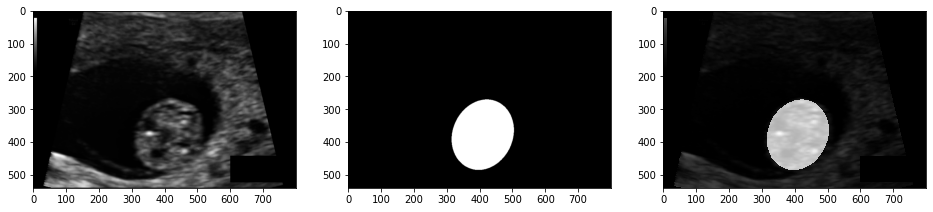

In [5]:

img = np.array(Image.open(trainPath+"000_HC.png"))
img_mask = np.array(Image.open(trainPath+"000_HC_Annotation.png"))
img_mask = np.ma.masked_where(img_mask == 0, img_mask)
print(len(img[0]))
#display images with mask
fig, ax = plt.subplots(1,3,figsize = (16,12))
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(img_mask, cmap = 'gray')
ax[2].imshow(img, cmap = 'gray', interpolation = 'none')
ax[2].imshow(img_mask, cmap = 'gray', interpolation = 'none', alpha = 0.7)


In [6]:

#
X = []
y = []
for image, mask in zip(train_image, train_mask):
    X.append(np.array(Image.open(trainPath+image)))
    y.append(np.array(Image.open(trainPath+mask)))

X = np.array(X)
y = np.array(y)

print("X_shape : ", X.shape)
print("y_shape : ", y.shape)



X_shape :  (999,)
y_shape :  (999,)


<ipython-input-6-5829c98f866b>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(X)
<ipython-input-6-5829c98f866b>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(y)


In [7]:
import cv2
from skimage.transform import resize
from sklearn.model_selection import train_test_split

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Add
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


IMG_HEIGHT = 224
IMG_WIDTH = 224

In [8]:
def Generator(X_list, y_list, batch_size = 16):
    c = 0

    while(True):
        X = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        y = np.empty((batch_size, IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
        
        for i in range(c,c+batch_size):
            image = X_list[i]
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            mask =  y_list[i]
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    
            X[i - c] = image
            y[i - c] = mask
        
        X = X[:,:,:,np.newaxis] / 255
        y = y[:,:,:,np.newaxis] / 255
        
        c += batch_size
        if(c+batch_size >= len(X_list)):
            c = 0
        yield X, y

In [9]:
train_img_aug = []
train_mask_aug = []


for img, mask in zip(train_image, train_mask):
    img = cv2.imread(trainPath + img)
    mask = cv2.imread(trainPath + mask)
    train_img_aug.append(img)
    
    train_mask_aug.append(mask)
    img_lr = np.fliplr(img)
    mask_lr = np.fliplr(mask)

    img_up = np.flipud(img)
    mask_up = np.flipud(mask)

    img_lr_up = np.flipud(img_lr)
    mask_lr_up = np.flipud(mask_lr)

    img_up_lr = np.fliplr(img_up)
    mask_up_lr = np.fliplr(mask_up)

    train_img_aug.append(img_lr)
    train_mask_aug.append(mask_lr)

    train_img_aug.append(img_up)
    train_mask_aug.append(mask_up)

    train_img_aug.append(img_lr_up)
    train_mask_aug.append(mask_lr_up)

    train_img_aug.append(img_up_lr)
    train_mask_aug.append(mask_up_lr)

print(len(train_image))
print(len(train_img_aug))

999
4995


In [10]:
smooth=1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection +smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [11]:
# define building blocks
def BatchnormActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_block(x, filters, size, strides=(1,1), padding="same", activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchnormActivate(x)
    return x

def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchnormActivate(blockInput)
    x = conv_block(x, num_filters, (3,3))
    x = conv_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchnormActivate(x)
    return x

In [12]:

def build_Unet(input_layer, start_neurons, DropoutRatio = 0.5):
    

    """ Encoder """
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(input_layer)
    conv1 = residual_block(conv1,start_neurons * 1)
    conv1 = residual_block(conv1,start_neurons * 1, True)
    pool1 = MaxPooling2D((2, 2))(conv1)
    #pool1 = Dropout(DropoutRatio/2)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(pool1)
    conv2 = residual_block(conv2,start_neurons * 2)
    conv2 = residual_block(conv2,start_neurons * 2, True)
    pool2 = MaxPooling2D((2, 2))(conv2)
    #pool2 = Dropout(DropoutRatio)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(pool2)
    conv3 = residual_block(conv3,start_neurons * 4)
    conv3 = residual_block(conv3,start_neurons * 4, True)
    pool3 = MaxPooling2D((2, 2))(conv3)
    #pool3 = Dropout(DropoutRatio)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(pool3)
    conv4 = residual_block(conv4,start_neurons * 8)
    conv4 = residual_block(conv4,start_neurons * 8, True)
    pool4 = MaxPooling2D((2, 2))(conv4)
    #pool4 = Dropout(DropoutRatio)(pool4)


    """ Bridge """
    convm = Conv2D(start_neurons * 16, (3, 3), activation=None, padding="same")(pool4)
    convm = residual_block(convm,start_neurons * 16)
    convm = residual_block(convm,start_neurons * 16, True)



    """ Decoder """
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    #uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation=None, padding="same")(uconv4)
    uconv4 = residual_block(uconv4,start_neurons * 8)
    uconv4 = residual_block(uconv4,start_neurons * 8, True)
    
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])    
    #uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation=None, padding="same")(uconv3)
    uconv3 = residual_block(uconv3,start_neurons * 4)
    uconv3 = residual_block(uconv3,start_neurons * 4, True)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
        
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation=None, padding="same")(uconv2)
    uconv2 = residual_block(uconv2,start_neurons * 2)
    uconv2 = residual_block(uconv2,start_neurons * 2, True)
    
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(uconv1)
    uconv1 = residual_block(uconv1,start_neurons * 1)
    uconv1 = residual_block(uconv1,start_neurons * 1, True)
    
    """ Output """
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

In [13]:


#split training data
X_train, X_val, y_train, y_val = train_test_split(train_img_aug, train_mask_aug, test_size = 0.3, random_state = 1)

# set training parameters
epochs = 100
batch_size = 16
steps_per_epoch = int(len(X_train) / batch_size)
validation_steps = int(len(X_val) / batch_size)

train_gen = Generator(X_train, y_train, batch_size = batch_size)
val_gen = Generator(X_val, y_val, batch_size = batch_size)

# initialize our model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
output_layer = build_Unet(inputs, 16, 0.5)

# Define callbacks to save model with best val_dice_coef
checkpointer = ModelCheckpoint(filepath = 'best_model_224_res.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
model = Model(inputs=[inputs], outputs=[output_layer])
model.compile(optimizer=Adam(lr = 1e-5), loss=dice_coef_loss, metrics=['accuracy',dice_coef,specificity,sensitivity,precision,])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


 add_6 (Add)                    (None, 28, 28, 128)  0           ['conv2d_17[0][0]',              
                                                                  'conv2d_15[0][0]']              
                                                                                                  
 batch_normalization_17 (BatchN  (None, 28, 28, 128)  512        ['add_6[0][0]']                  
 ormalization)                                                                                    
                                                                                                  
 activation_17 (Activation)     (None, 28, 28, 128)  0           ['batch_normalization_17[0][0]'] 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 28, 28, 128)  147584      ['activation_17[0][0]']          
                                                                                                  
 batch_nor

In [14]:


results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer])



<ipython-input-14-350936afeb50>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  results = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs = epochs, validation_data = val_gen, validation_steps = validation_steps,callbacks=[checkpointer])


Epoch 1/100
218/218 [==============================] - ETA: 0s - loss: -0.4975 - accuracy: 0.5902 - dice_coef: 0.4975 - specificity: 0.4835 - sensitivity: 0.8553 - precision: 0.4119
Epoch 1: val_dice_coef improved from -inf to 0.36900, saving model to best_model_224_res.h5
218/218 [==============================] - 94s 365ms/step - loss: -0.4975 - accuracy: 0.5902 - dice_coef: 0.4975 - specificity: 0.4835 - sensitivity: 0.8553 - precision: 0.4119 - val_loss: -0.3690 - val_accuracy: 0.6226 - val_dice_coef: 0.3690 - val_specificity: 0.7312 - val_sensitivity: 0.3690 - val_precision: 0.3605
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: -0.6890 - accuracy: 0.8354 - dice_coef: 0.6890 - specificity: 0.7822 - sensitivity: 0.9775 - precision: 0.6607
Epoch 2: val_dice_coef improved from 0.36900 to 0.72050, saving model to best_model_224_res.h5
218/218 [==============================] - 80s 368ms/step - loss: -0.6890 - accuracy: 0.8354 - dice_coef: 0.6890 - specificity: 0

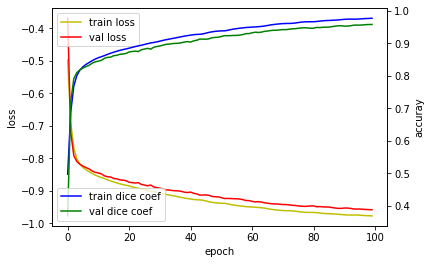

In [15]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

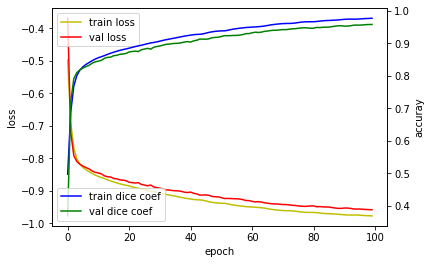

In [16]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['dice_coef'], 'b', label='train dice coef')
acc_ax.plot(results.history['val_dice_coef'], 'g', label='val dice coef')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

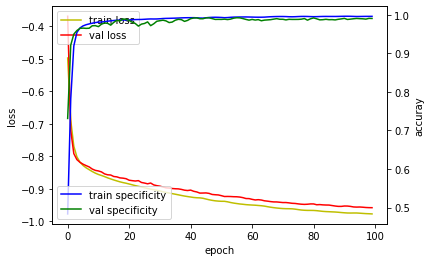

In [17]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['specificity'], 'b', label='train specificity')
acc_ax.plot(results.history['val_specificity'], 'g', label='val specificity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

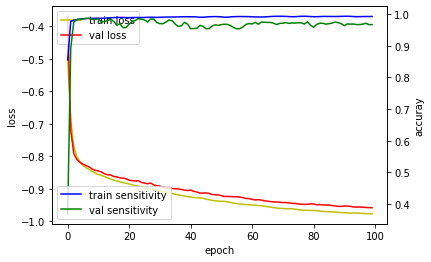

In [18]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['sensitivity'], 'b', label='train sensitivity')
acc_ax.plot(results.history['val_sensitivity'], 'g', label='val sensitivity')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

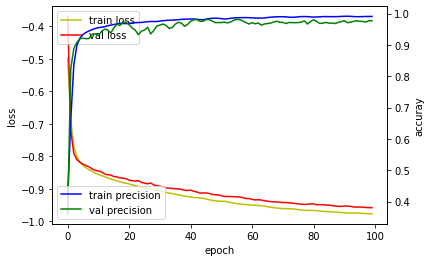

In [19]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(results.history['loss'], 'y', label='train loss')
loss_ax.plot(results.history['val_loss'], 'r', label='val loss')

acc_ax.plot(results.history['precision'], 'b', label='train precision')
acc_ax.plot(results.history['val_precision'], 'g', label='val precision')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [20]:
print(results.history['precision'][-1])

0.9910860061645508


In [21]:
print(results.history['dice_coef'][-1])

0.9774009585380554


In [22]:
print(results.history['specificity'][-1])

0.9961624145507812


In [23]:

# import os
test_list = os.listdir("test_set/")
print("The number of test data : ", len(test_list))
test_list[:5]



The number of test data :  335


['001_HC.png', '000_HC.png', '003_HC.png', '004_HC.png', '002_HC.png']

In [24]:
#used just for prediction, not as a checkpoint
model = tf.keras.models.load_model('best_model_224_res.h5', compile=False)

In [25]:


X_test = np.empty((len(test_list), IMG_HEIGHT, IMG_WIDTH), dtype = 'float32')
for i, item in enumerate(test_list):
    image = cv2.imread("test_set/" + item, 0)
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    X_test[i] = image
X_test = X_test[:,:,:,np.newaxis] / 255

y_pred = model.predict(X_test)



11/11 [==============================] - 4s 210ms/step


(108.27601623535156, 108.81373596191406) (123.19168090820312, 149.2501220703125) 88.75541687011719
(108.27601623535156, 108.81373596191406) (123.19168090820312, 149.2501220703125) 88.75541687011719
(109.31278228759766, 135.73214721679688) (45.96809005737305, 82.66016387939453) 80.64422607421875
(105.84724426269531, 83.14088439941406) (83.239013671875, 111.18412780761719) 80.77891540527344
(117.16844940185547, 101.52874755859375) (129.29324340820312, 154.03652954101562) 89.675537109375
(113.49003601074219, 112.45454406738281) (102.14398193359375, 120.8623046875) 90.8206787109375
(115.03974151611328, 123.13088989257812) (50.54014205932617, 105.97718048095703) 100.70735931396484
(126.45454406738281, 117.62322235107422) (79.07256317138672, 91.7459487915039) 68.81288146972656
(111.63909912109375, 107.20097351074219) (78.45648956298828, 106.405029296875) 100.02753448486328
(122.25077056884766, 124.82726287841797) (141.86904907226562, 155.64329528808594) 90.09590911865234
(94.9626693725586, 9

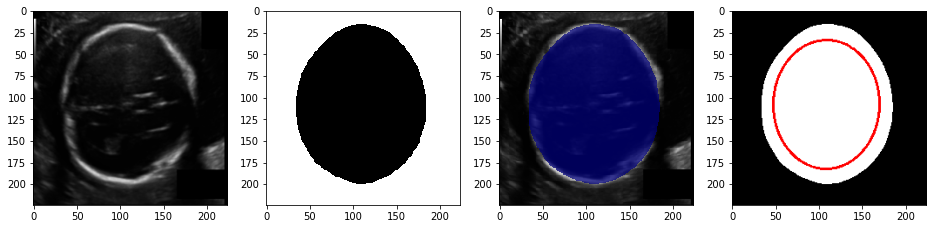

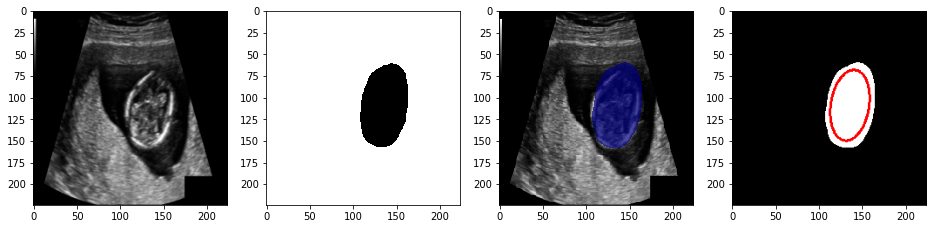

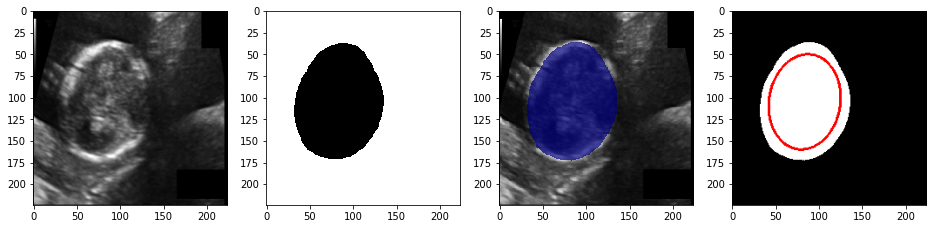

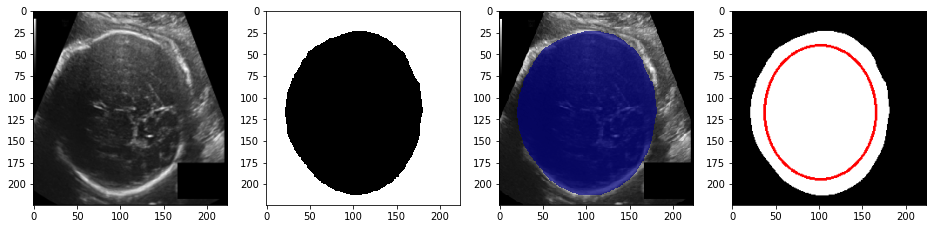

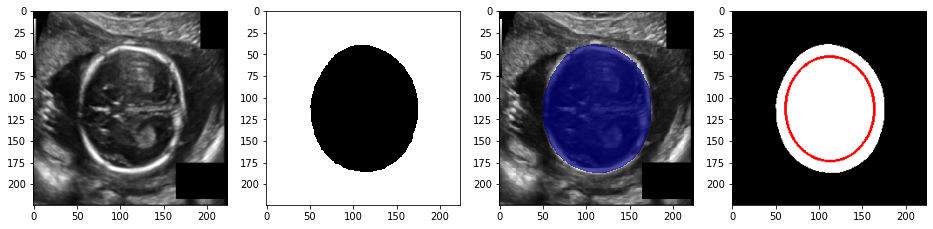

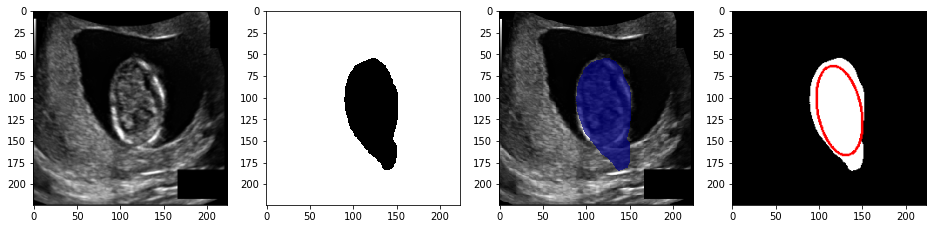

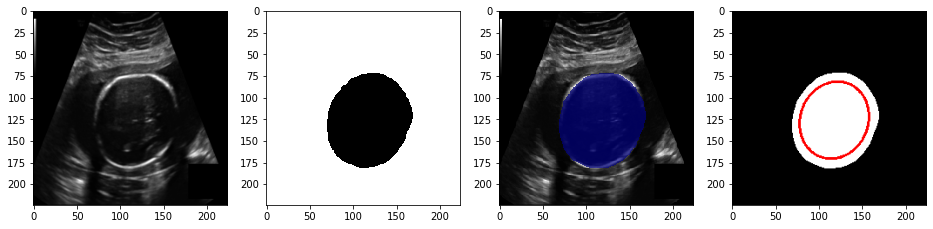

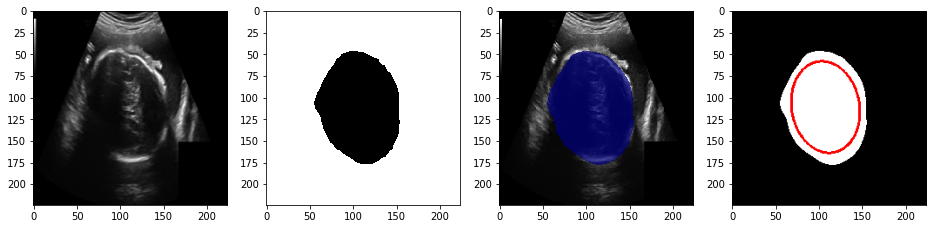

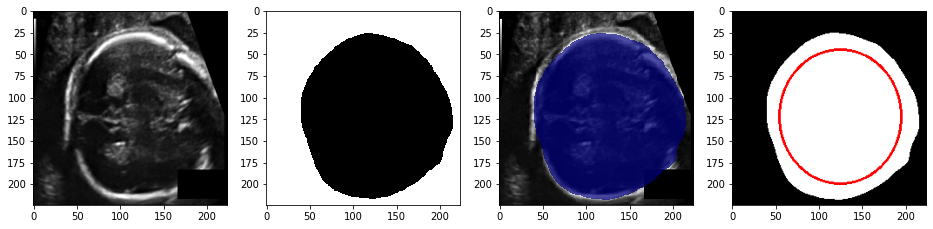

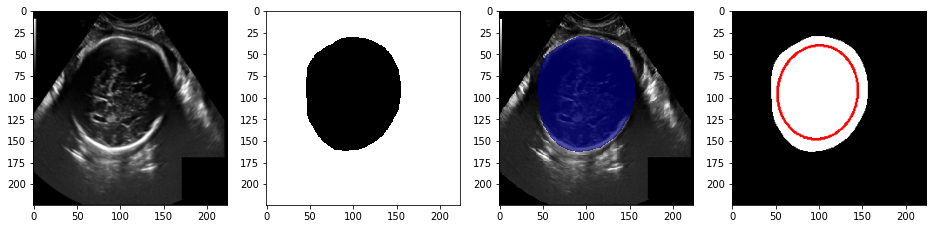

In [32]:

def fitEllipse(binary_mask, method="Direct"):
    assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0
    points = np.argwhere(binary_mask > 0.5)  

    if method == "AMS":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
    elif method == "Direct":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
    elif method == "Simple":
        (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

    return (xx, yy), (MA, ma), angle


img = pred.copy()
(xx, yy), (MA, ma), angle = fitEllipse(img)
print((xx, yy), (MA, ma), angle)

draw = np.zeros((*img.shape, 3), dtype=np.uint8)

draw[img > 0.5] = (255,) * 3

cv2.ellipse(
    draw,
    (int(yy), int(xx)),
    (int(ma / 2), int(MA / 2)),
    -angle,
    0,
    360,
    color=(255, 0, 0),
    thickness=2,
)

for test, pred in zip(X_test[180:190],y_pred[180:190]):
    fig, ax = plt.subplots(1,4,figsize = (16,16))
    test = test.reshape((IMG_HEIGHT,IMG_WIDTH))

    pred = pred.reshape((IMG_HEIGHT,IMG_WIDTH))



    img = pred.copy()
    (xx, yy), (MA, ma), angle = fitEllipse(img)
    print((xx, yy), (MA, ma), angle)

    draw = np.zeros((*img.shape, 3), dtype=np.uint8)

    draw[img > 0.5] = (255,) * 3

    cv2.ellipse(
        draw,
        (int(yy), int(xx)),
        (int(ma / 2), int(MA / 2)),
        -angle,
        0,
        360,
        color=(255, 0, 0),
        thickness=2,
    )
    
    pred = pred>0.5
    pred = np.ma.masked_where(pred == 0, pred)

    ax[0].imshow(test, cmap = 'gray')

    ax[1].imshow(pred, cmap = 'gray')

    ax[2].imshow(test, cmap = 'gray', interpolation = 'none')
    ax[2].imshow(pred, cmap = 'jet', interpolation = 'none', alpha = 0.7)
    ax[3].imshow(draw,cmap='jet')

(94.9626693725586, 98.8033676147461) (92.15882873535156, 109.25697326660156) 82.1634292602539


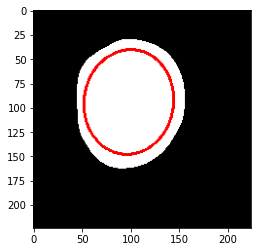

In [27]:
def fitEllipse(binary_mask, method="Direct"):
    assert binary_mask.min() >= 0.0 and binary_mask.max() <= 1.0
    points = np.argwhere(binary_mask > 0.5)  

    if method == "AMS":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseAMS(points)
    elif method == "Direct":
        (xx, yy), (MA, ma), angle = cv2.fitEllipseDirect(points)
    elif method == "Simple":
        (xx, yy), (MA, ma), angle = cv2.fitEllipse(points)

    return (xx, yy), (MA, ma), angle


# img = np.load("./output_samples/3.npy")
img = pred.copy()
(xx, yy), (MA, ma), angle = fitEllipse(img)
print((xx, yy), (MA, ma), angle)

draw = np.zeros((*img.shape, 3), dtype=np.uint8)

draw[img > 0.5] = (255,) * 3

cv2.ellipse(
    draw,
    (int(yy), int(xx)),
    (int(ma / 2), int(MA / 2)),
    -angle,
    0,
    360,
    color=(255, 0, 0),
    thickness=2,
)

plt.imshow(draw)
plt.show()
